In [1]:
import mne
import mne_bids
import os, os.path as op
import nilearn
import matplotlib.pyplot as plt

from nilearn import *

In [2]:
t1_bids_path=mne_bids.get_bids_path_from_fname('/data/MEG_workshop_data/ds004215/sub-ON02811/ses-01/anat/sub-ON02811_ses-01_acq-MPRAGE_T1w.nii.gz')

In [3]:
bids_root = '/data/MEG_workshop_data/ds004215'
deriv_root = op.join(bids_root, 'derivatives')
fs_subjects_dir = op.join(deriv_root, 'freesurfer','subjects')

In [4]:
subject = 'ON02811'
bids_path = mne_bids.BIDSPath(root=bids_root, subject = subject, session='01', task='airpuff', run='01', datatype='meg')
bids_deriv_path = bids_path.copy().update(root=op.join(bids_root, 'derivatives', 'MEGworkshop'), check=False)
if not op.exists(bids_deriv_path.root): os.mkdir(bids_deriv_path.root)

#t1_bids_path = bids_path.copy().update(datatype='anat', session=None, task=None, run='01')

In [6]:
raw = mne.io.read_raw_ctf(bids_path.fpath, clean_names=True, preload=True, verbose=False)
# raw = mne_bids.read_raw_bids(bids_path, verbose=False, preload=True)

In [7]:
trans = mne_bids.get_head_mri_trans(bids_path, extra_params={'clean_names': True}, t1_bids_path=t1_bids_path, fs_subject='sub-'+subject, fs_subjects_dir=fs_subjects_dir, verbose=False)

/tmp/ipykernel_76306/4241046088.py:1: RuntimeWarning: The unit for channel(s) SCLK01-177, UADC001-2104, UPPT001, trigger has changed from V to NA.
  trans = mne_bids.get_head_mri_trans(bids_path, extra_params={'clean_names': True}, t1_bids_path=t1_bids_path, fs_subject='sub-'+subject, fs_subjects_dir=fs_subjects_dir, verbose=False)


### Prepare Imaging for Source Localization

In [8]:
fwd_name = bids_deriv_path.copy().update(extension='.fif', suffix='volfwd')
fwd = mne.read_forward_solution(fwd_name)
src = fwd['src']

Reading forward solution from /data/MEG_workshop_data/ds004215/derivatives/MEGworkshop/sub-ON02811/ses-01/meg/sub-ON02811_ses-01_task-airpuff_run-01_volfwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (9596 sources, 272 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


/tmp/ipykernel_76306/933157568.py:2: RuntimeWarning: This filename (/data/MEG_workshop_data/ds004215/derivatives/MEGworkshop/sub-ON02811/ses-01/meg/sub-ON02811_ses-01_task-airpuff_run-01_volfwd.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(fwd_name)


In [9]:
evts, evtsid = mne.events_from_annotations(raw)

Used Annotations descriptions: ['missingstim', 'stim']


In [10]:
epochs = mne.Epochs(raw, evts, evtsid, tmin=-0.1, tmax=0.2, preload=True)

Not setting metadata
500 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 500 events and 361 original time points ...
0 bad epochs dropped


In [26]:
evk_stim = epochs['stim'].average()
evk_mssingstim = epochs['missingstim'].average()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [19]:
%matplotlib qt
evk.plot()

Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 640x300 with 2 Axes>

## Multi-dipole (not available)

## MNE solution

In [27]:
cov = mne.compute_covariance(epochs['stim'], tmin=0, tmax = 0.1, method='shrunk', cv=5)

Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from data with rank=None
    Using tolerance 2.3e-08 (2.2e-16 eps * 272 dim * 3.9e+05  max singular value)
    Estimated rank (mag): 272
    MAG: rank 272 computed from 272 data channels with 0 projectors
Reducing data rank from 272 -> 272
Estimating covariance using SHRUNK
Done.
Number of samples used : 51425
[done]


In [29]:
evk_stim.crop(0,0.1)

<Evoked | 'stim' (average, N=425), 0 – 0.1 s, baseline -0.1 – 0 s (baseline period was cropped after baseline correction), 300 ch, ~672 kB>

In [17]:
bem_fname = bids_deriv_path.copy().update(suffix='bemsol', extension='.fif')

In [30]:
dip = mne.fit_dipole(evk_stim, cov, bem_fname.fpath, trans=trans)

BEM               : PosixPath('/data/MEG_workshop_data/ds004215/derivatives/MEGworkshop/sub-ON02811/ses-01/meg/sub-ON02811_ses-01_task-airpuff_run-01_bemsol.fif')
MRI transform     : instance of Transform
Head origin       :   -1.6    2.7   59.1 mm rad =   69.5 mm.
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : <Covariance | size : 272 x 272, n_samples : 51424, data : [[ 8.65481831e-27  5.09174222e-27  4.20639237e-27 ... -2.82921339e-27
  -2.65904986e-27 -1.00776831e-27]
 [ 5.09174222e-27  8.46065914e-27  6.61324798e-27 ... -1.98008935e-27
  -2.27055200e-27  1.93345423e-28]
 [ 4.20639237e-27  6.61324798e-27  1.21068704e-26 ... -1.50191822e-27
  -2.25101689e-27  8.69054385e-28]
 ...
 [-2.82921339e-27 -1.98008935e-27 -1.50191822e-27 ...  2.77675273e-26
   1.74677145e-26  1.27371549e-26]
 [-2.65904986e-27 -2.27055200e-27 -2.25101689e-27 ...  1.74677145e-26
   2.97711417e-26  4.36202123e-27]
 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   32.5s


---- Fitted :    14.2 ms, distance to inner skull : 4.9633 mm
---- Fitted :    15.0 ms, distance to inner skull : 4.9619 mm
---- Fitted :    15.8 ms, distance to inner skull : 4.9510 mm
---- Fitted :    16.7 ms, distance to inner skull : 13.7597 mm
---- Fitted :    17.5 ms, distance to inner skull : 15.9771 mm
---- Fitted :    18.3 ms, distance to inner skull : 15.0968 mm
---- Fitted :    19.2 ms, distance to inner skull : 13.4875 mm
---- Fitted :    20.0 ms, distance to inner skull : 11.7416 mm
---- Fitted :    20.8 ms, distance to inner skull : 10.8860 mm
---- Fitted :    21.7 ms, distance to inner skull : 11.5863 mm
---- Fitted :    22.5 ms, distance to inner skull : 11.2664 mm
---- Fitted :    23.3 ms, distance to inner skull : 4.9677 mm
---- Fitted :    24.2 ms, distance to inner skull : 4.9629 mm
---- Fitted :    25.0 ms, distance to inner skull : 4.9178 mm
---- Fitted :    25.8 ms, distance to inner skull : 7.8327 mm
---- Fitted :    26.7 ms, distance to inner skull : 9.5521 mm


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:  2.1min


---- Fitted :    59.2 ms, distance to inner skull : 17.1724 mm
---- Fitted :    60.0 ms, distance to inner skull : 4.9641 mm
---- Fitted :    60.8 ms, distance to inner skull : 4.9750 mm
---- Fitted :    61.7 ms, distance to inner skull : 5.0009 mm
---- Fitted :    62.5 ms, distance to inner skull : 18.0333 mm
---- Fitted :    63.3 ms, distance to inner skull : 20.5223 mm
---- Fitted :    64.2 ms, distance to inner skull : 8.7186 mm
---- Fitted :    65.0 ms, distance to inner skull : 19.5079 mm
---- Fitted :    65.8 ms, distance to inner skull : 13.9602 mm
---- Fitted :    66.7 ms, distance to inner skull : 11.8434 mm
---- Fitted :    67.5 ms, distance to inner skull : 14.1858 mm
---- Fitted :    68.3 ms, distance to inner skull : 17.8991 mm
---- Fitted :    69.2 ms, distance to inner skull : 18.1149 mm
---- Fitted :    70.0 ms, distance to inner skull : 16.5338 mm
---- Fitted :    70.8 ms, distance to inner skull : 15.3576 mm
---- Fitted :    71.7 ms, distance to inner skull : 14.9812

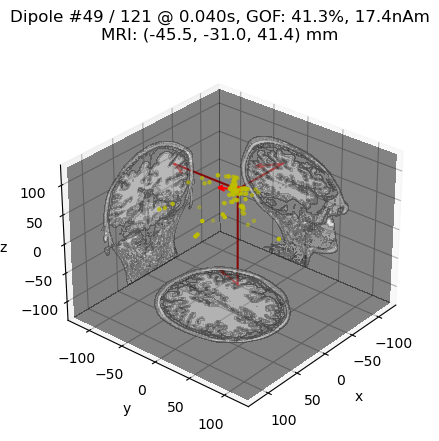

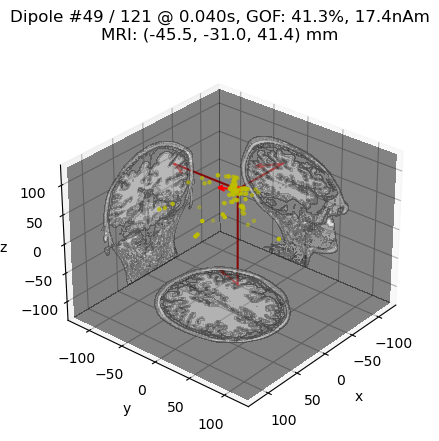

In [31]:
dip[0].plot_locations(trans, 'sub-'+subject, fs_subjects_dir, mode="orthoview")

In [36]:
%matplotlib qt
dip[1].plot()

<IPython.core.display.Javascript object>

Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


<IPython.core.display.Javascript object>

In [37]:
dipole = dip[0]

In [40]:
dipevk = dip[1]

In [42]:
import pylab

In [43]:
pylab.plot(dipevk.times, dipevk.get_data())

<IPython.core.display.Javascript object>

ValueError: x and y must have same first dimension, but have shapes (121,) and (300, 121)